In [1]:
import sys
print(sys.prefix)

C:\Users\jmjeon\anaconda3\envs\ml_study


# Decision Tree (의사결정나무)

- 쉽게 말하면 스무고개를 통해 원래 데이터가 어디에 속하는지 알아나가는 모델로, 회귀와 분류가 모두 가능한 지도 학습 모델
- terminal node의 종속변수의 평균을 예측값으로 반환하므로 예측값의 종류는 terminal node의 개수와 일치한다.
- 계산의 복잡성 대비 높은 예측 성능을 가지며, 변수단위로 설명력을 가지는 것이 장점이다.
- 하지만 overfitting의 가능성이 있다는 단점이 있으며 해당 단점을 극복하기 위한 모델이 Random Forest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from IPython.display import Image, display

# %matplotlib inline

# Decision Tree (Regression)
- 목표 : 야구 선수들의 시즌 및 통산 경기 기록, 수비 능력, 리그 정보 등 다양한 데이터를 기반으로 선수의 연봉(Salary)을 예측하는 의사결정나무 회귀 모델을 구축
- 어떤 변수가 연봉에 영향을 많이 미치는지 분석

- 회귀모델은 오차가 가장 줄어드는 조건(값이 비슷한 그룹으로 나눔)을 선택해서 계속 반복하여 학습한다.
- 회귀모델에서는 MSE(Mean Squared Error)가 최소가 되는 방향으로 모델 학습이 이루어진다.

## 1. Data load

In [158]:
# read data
hitters_df = pd.read_csv('../data/Hitters.csv', index_col=0)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [159]:
hitters_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

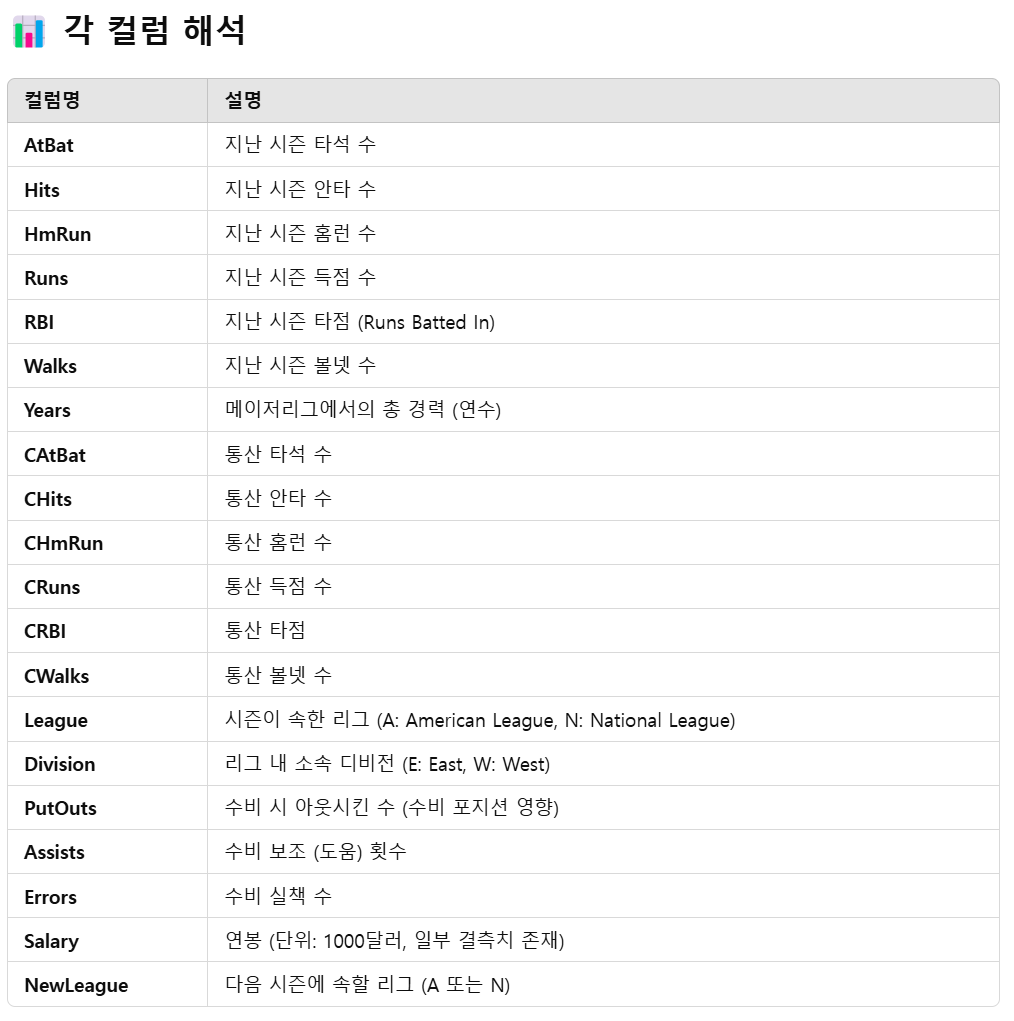

In [5]:
display(Image(filename='../image/decision_tree_regression_col_info.png', width=600))

In [161]:
hitters_df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


## 2. Preprocessing

### 2-1. null 제거

In [162]:
hitters_df.dropna(how='any', inplace=True)
hitters_df.shape

(263, 20)

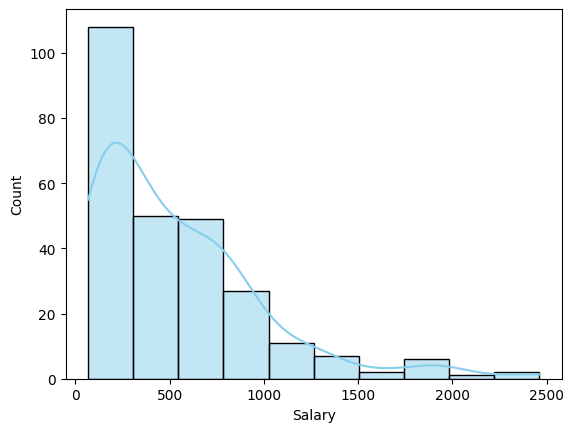

In [163]:
sns.histplot(data=hitters_df, x='Salary', bins=10, kde=True, color='skyblue')
plt.show()

## 2-2. y값 log 변환

In [164]:
# Salary(y값) log변환
hitters_df['Salary'] = np.log(hitters_df['Salary'])
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


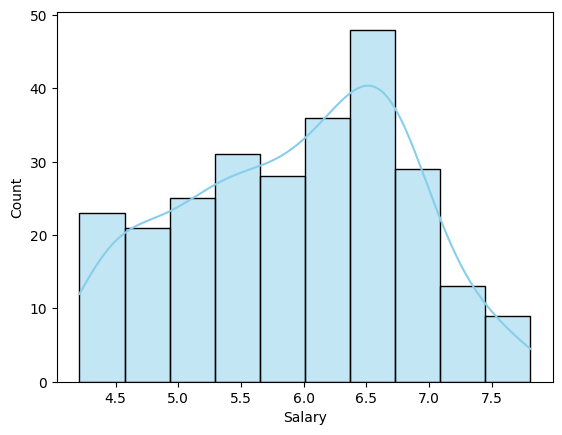

In [165]:
sns.histplot(data=hitters_df, x='Salary', bins=10, kde=True, color='skyblue')
plt.show()

## 3. Modeling

### 3-1. Decision tree test 
- 2가지 변수로만 테스트

In [192]:
X = hitters_df[['Years', 'Hits']]
y = hitters_df[['Salary']]

reg_tree = DecisionTreeRegressor(max_leaf_nodes=3)
reg_tree.fit(X,y)

DecisionTreeRegressor(max_leaf_nodes=3)

- 트리 구조 시각화

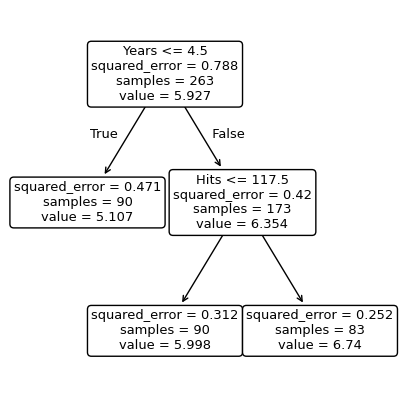

In [194]:
plt.figure(figsize=(5,5))
plot_tree(reg_tree,
          feature_names=X.columns,
          rounded=True)
plt.show()

- 데이터 분기 시각화

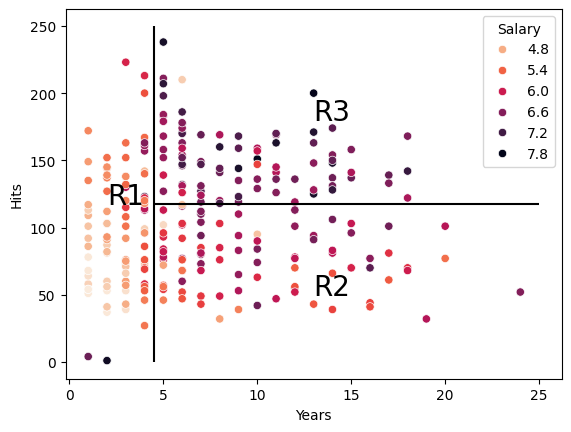

In [195]:
palette = sns.color_palette("rocket_r", as_cmap=True)
s = sns.scatterplot(x='Years', y='Hits', hue='Salary', data=hitters_df, palette=palette)

plt.vlines(4.5, ymin=0, ymax=250, colors='black')
plt.hlines(117.5, xmin=4.5, xmax=25, colors='black')
plt.annotate('R1', xy=(2, 117.5), fontsize=20)
plt.annotate('R2', xy=(13, 50), fontsize=20)
plt.annotate('R3', xy=(13, 180), fontsize=20)

plt.show()

### 3-2. Decision Tree 학습

In [196]:
X = hitters_df.drop('Salary', axis=1)
X = pd.get_dummies(X) # 범주형 변수의 경우 dummy화 필요 (원핫인코딩)
y = hitters_df[['Salary']]

print(X.shape, y.shape)

(263, 22) (263, 1)


In [197]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
print(X_train.shape, X_test.shape)

(210, 22) (53, 22)


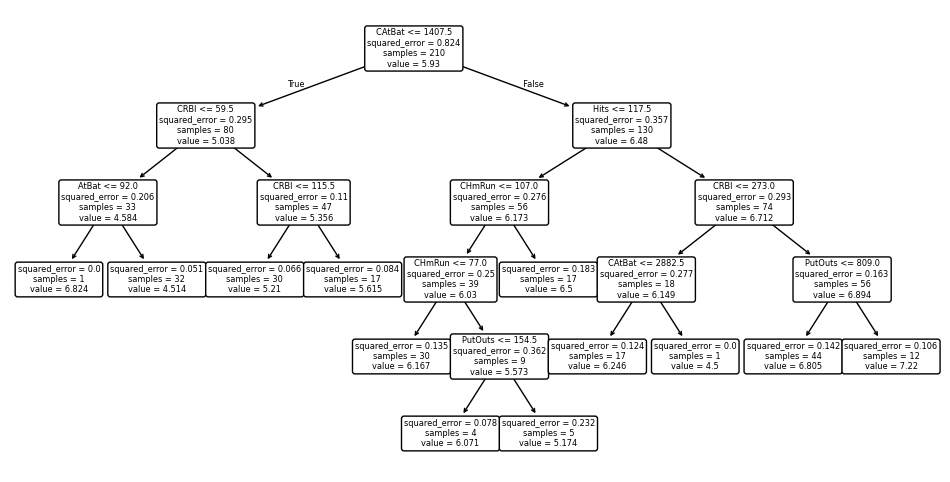

In [199]:
reg_tree = DecisionTreeRegressor(max_leaf_nodes=12)
reg_tree.fit(X_train,y_train)

plt.figure(figsize=(12,6))
plot_tree(reg_tree,
          feature_names=X.columns,
          rounded=True)
plt.show()

- 최적의 하이퍼 파라미터 찾기

In [200]:
param_grid = {
    'max_depth': [2, 3, 4, 5, None],
    'max_leaf_nodes': [5, 10, 20, 30],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

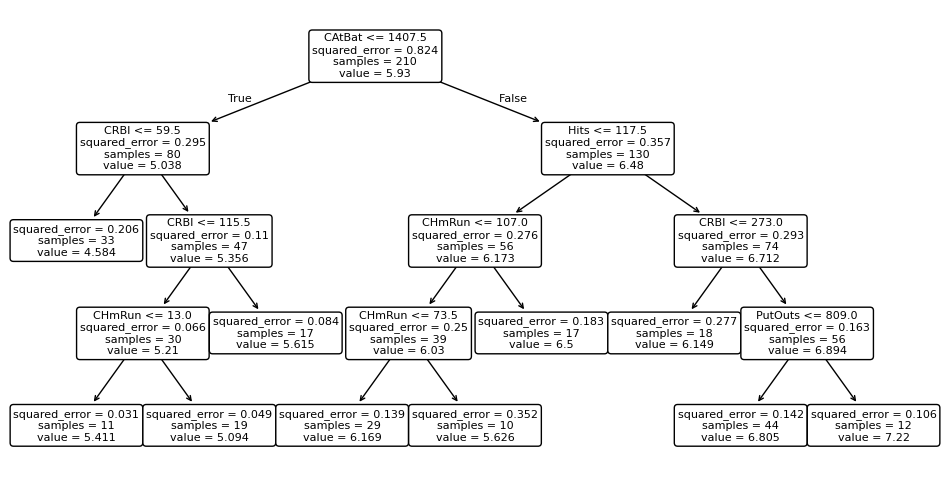

In [205]:
plt.figure(figsize=(12,6))
plot_tree(best_model,
          feature_names=X_train.columns,
          rounded=True)
plt.show()

In [202]:
y_pred = best_model.predict(X_test)

In [203]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid.best_params_)
print("Test RMSE:", round(rmse, 2))
print("Test R²:", round(r2, 4))

Best Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Test RMSE: 0.61
Test R²: 0.4207


In [156]:
# y값 log 변환 전 성능

# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print("Best Parameters:", grid.best_params_)
# print("Test RMSE:", round(rmse, 2))
# print("Test R²:", round(r2, 4))

Best Parameters: {'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Test RMSE: 419.93
Test R²: 0.025


- feature importance 확인

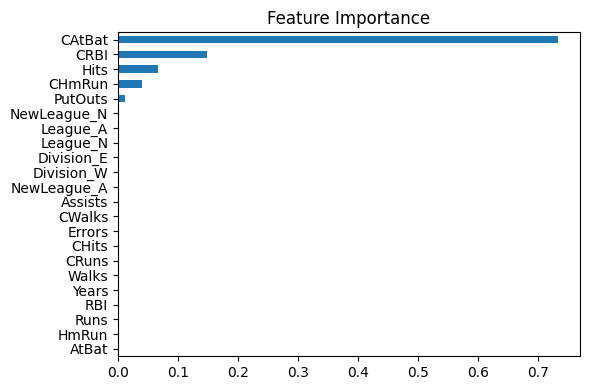

In [204]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(6, 4), title='Feature Importance')
plt.tight_layout()
plt.show()

- 최적의 하이퍼파라미터와 중요 Feature(3개)를 활용하여 최적의 Decision Tree 학습

In [208]:
top_features = importances.sort_values(ascending=False).head(3).index.tolist()

In [210]:
# 중요 피처만 사용해 다시 모델 학습
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [2, 3, 4, 5, None],
    'max_leaf_nodes': [5, 10, 20, 30],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

final_best_model = grid.best_estimator_

In [214]:
y_pred = final_best_model.predict(X_test)

In [215]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid.best_params_)
print("Test RMSE:", round(rmse, 2))
print("Test R²:", round(r2, 4))

Best Parameters: {'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Test RMSE: 0.57
Test R²: 0.4952


# Decision Tree (Classfication)
- 목표 : 건강 정보(나이, 흉통 유형, 콜레스테롤 수치 등)를 기반으로 심장 질환 여부(AHD) 를 예측하는 의사결정나무(Decision Tree) 분류 모델을 구축
- 환자 상태에 따라 질환 가능성을 조기에 판단 가능

- 분류모델에서는 순도(Homogeneity)가 증가, 불순도(Impurity) 혹은 불확실성(Uncertainty)가 최대한 감소하는 방향으로 학습을 진행한다.
- 분류모델에서는 엔트로피(Entropy), 지니계수(Gini Index)가 최소가 되는 방향으로 모델 학습이 이루어진다.

## 1. Data load

In [29]:
# read data
heart_df = pd.read_csv('../data/Heart.csv', index_col=0)
heart_df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [30]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 35.5+ KB


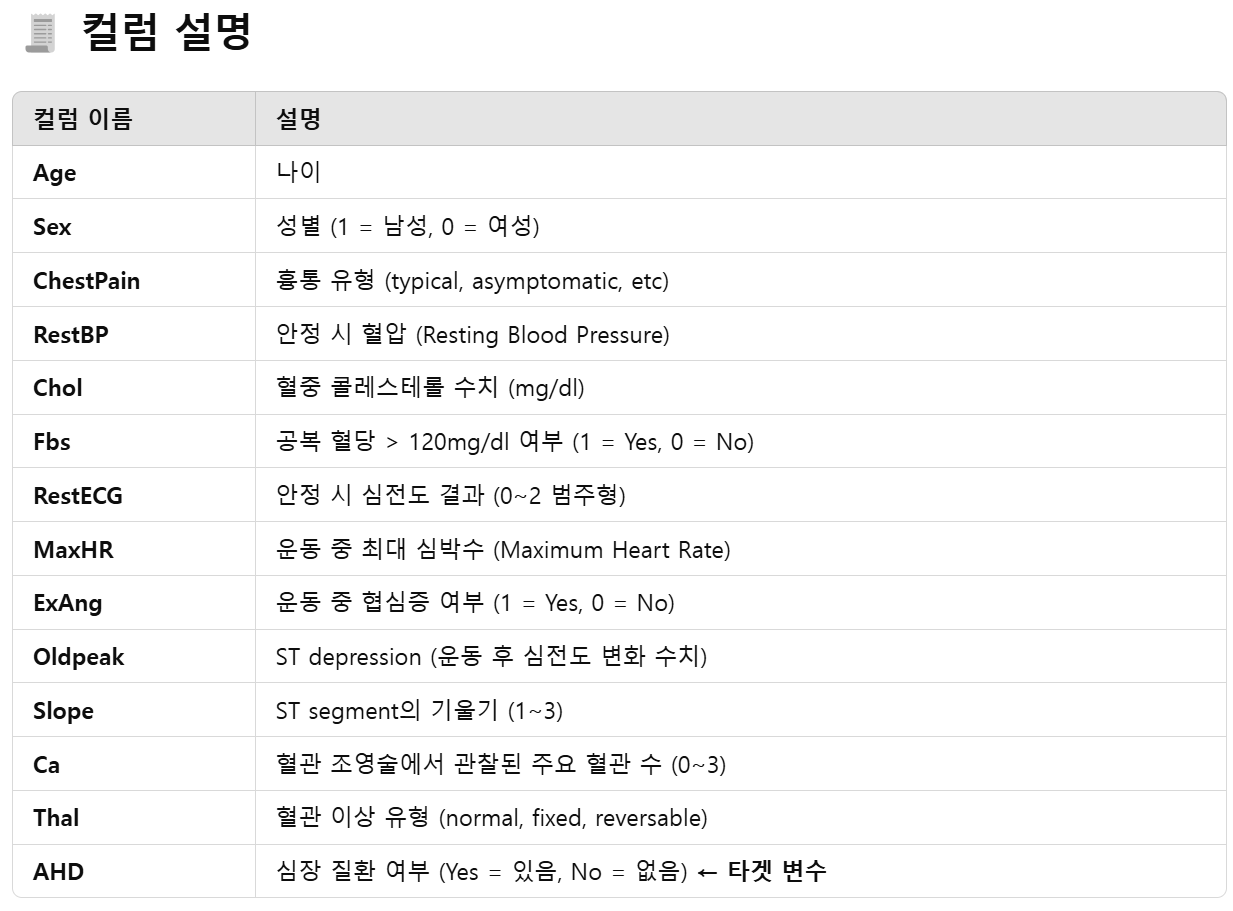

In [31]:
display(Image(filename='../image/decision_tree_classification_col_info.png', width=600))

In [32]:
heart_df.describe()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [33]:
heart_df.describe(include='object')

,ChestPain,Thal,AHD
count,303,301,303
unique,4,3,2
top,asymptomatic,normal,No
freq,144,166,164


In [34]:
heart_df.ChestPain.unique()

array(['typical', 'asymptomatic', 'nonanginal', 'nontypical'],
      dtype=object)

## 2. Preprocessing

### 2-1. null 제거

In [35]:
heart_df.dropna(how='any', inplace=True)
heart_df.shape

(297, 14)

### 2-2. train test split

In [36]:
X = heart_df.drop('AHD', axis=1)
y = heart_df['AHD']
y = y.apply(lambda x: 1 if x.strip() == 'Yes' else 0) # 문자열 시작 끝 공백 제거

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train)

(237, 13) (60, 13)
54     0
268    1
97     1
266    1
236    1
      ..
108    1
84     1
18     0
234    0
100    0
Name: AHD, Length: 237, dtype: int64


### 2-3. Encoding

- one-hot encoding, label encoding, ordinal encoding 비교

In [37]:
# one-hot encding, 간단하게 하려면 get_dummies 함수 괜찮음
X_train_oe=pd.get_dummies(X_train)
X_test_oe=pd.get_dummies(X_test)
print(X_train_oe.shape, X_test_oe.shape)

(237, 18) (60, 18)


In [38]:
# label encoding
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le_chest = preprocessing.LabelEncoder()
le_thal = preprocessing.LabelEncoder()

X_train_le['ChestPain'] = le_chest.fit_transform(X_train_le['ChestPain'])
X_test_le['ChestPain'] = le_chest.transform(X_test_le['ChestPain'])

X_train_le['Thal'] = le_thal.fit_transform(X_train_le['Thal'])
X_test_le['Thal'] = le_thal.transform(X_test_le['Thal'])

## 3. Modeling

In [39]:
ci_tree_oe = DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)
ci_tree_oe.fit(X_train_oe, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)

In [60]:
y_pred = ci_tree_oe.predict(X_test_oe)
y_proba = ci_tree_oe.predict_proba(X_test_oe)

In [40]:
ci_tree_le = DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)
ci_tree_le.fit(X_train_le, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)

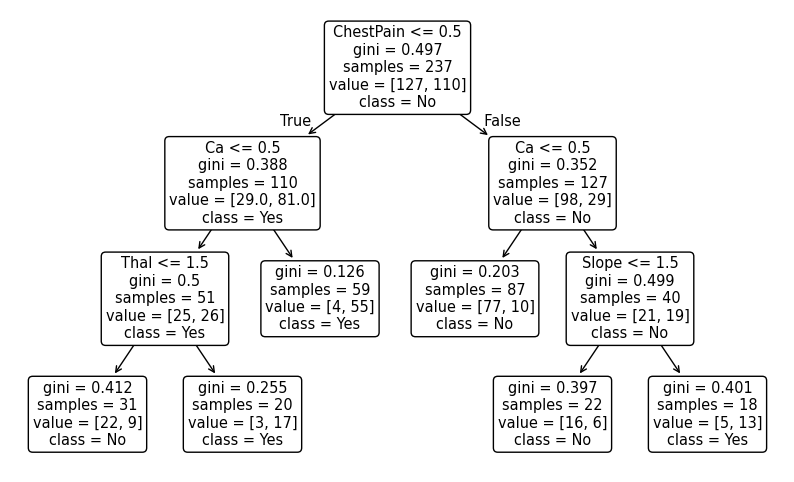

In [54]:
# 트리 구조 시각화
plt.figure(figsize=(10, 6))
plot_tree(ci_tree_le, 
          feature_names=X_train_le.columns, 
          rounded=True,
          class_names=['No', 'Yes'])
plt.show()

In [41]:
# 두 모델의 정확도 비교
print('onehot encoding result: ', round(ci_tree_oe.score(X_test_oe, y_test), 4))
print('label encoding result: ', round(ci_tree_le.score(X_test_le, y_test), 4))

onehot encoding result:  0.8833
label encoding result:  0.8833


In [42]:
from sklearn.preprocessing import OrdinalEncoder
# label encoding

X_train_od = X_train.copy()
X_test_od = X_test.copy()

od_chest = OrdinalEncoder(categories=[['nonanginal', 'nontypical', 'typical', 'asymptomatic']])
od_thal = OrdinalEncoder(categories=[['normal', 'fixed', 'reversable']])

X_train_od['ChestPain'] = od_chest.fit_transform(X_train_od[['ChestPain']])
X_test_od['ChestPain'] = od_chest.transform(X_test_od[['ChestPain']])

X_train_od['Thal'] = od_thal.fit_transform(X_train_od[['Thal']])
X_test_od['Thal'] = od_thal.transform(X_test_od[['Thal']])

In [43]:
ci_tree_od = DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)
ci_tree_od.fit(X_train_od, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=7)

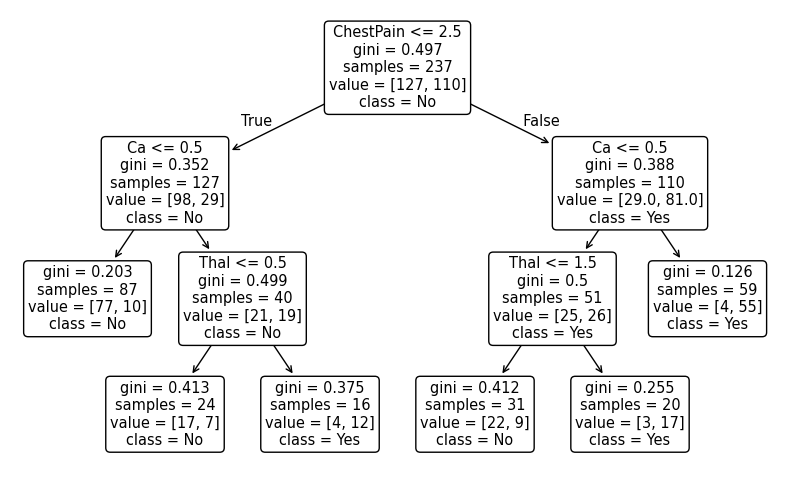

In [53]:
# 트리 구조 시각화
plt.figure(figsize=(10, 6))
plot_tree(ci_tree_od, 
          feature_names=X_train_od.columns, 
          rounded=True,
          class_names=['No', 'Yes'])
plt.show()

In [44]:
print('ordinary encoding result: ', round(ci_tree_od.score(X_test_od, y_test), 4))

ordinary encoding result:  0.8833


다양한 인코딩 방식을 적용하여 모델의 정확도를 비교해본 결과,
트리 계열 모델에서는 숫자의 "의미"보다는 범주 간 그룹을 어떻게 나누는지가 더 중요하기 때문에,
Label Encoding, Ordinal Encoding, One-Hot Encoding 간에 성능 차이가 거의 없거나 유사한 수준을 보였다.
반면, 선형 모델이나 거리 기반 모델(Logistic Regression, SVM, KNN 등)은 숫자의 크기나 간격을 그대로 해석하기 때문에,
순서가 없는 범주형 변수에는 One-Hot Encoding, 순서가 있는 변수에는 Ordinal Encoding을 사용하는 것이 적절하다.

### 4. 결과 시각화 및 평가지표 확인

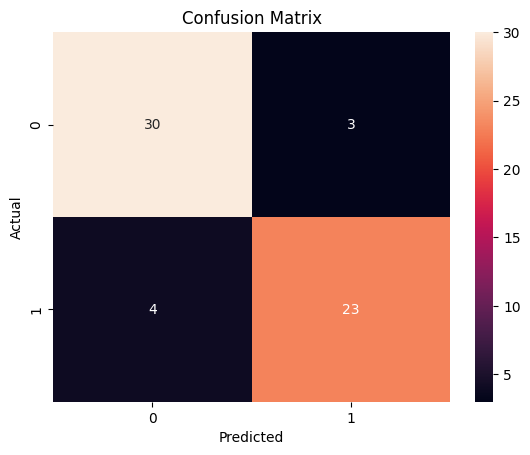


[Confusion Report]

               precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.88      0.85      0.87        27

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [55]:
def get_confusion_mt(model, _X_test, _y_test):
    y_pred = model.predict(_X_test)
    confusion_mt = pd.crosstab(_y_test.values.ravel(), y_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
    return confusion_mt

def get_confusion_report(model, _X_test, _y_test):
    y_pred = model.predict(_X_test)
    return classification_report(_y_test, y_pred)

# confusion matrix 산출 
confusion_mt = get_confusion_mt(ci_tree_oe, X_test_oe, y_test)

# confusion matrix 시각화
fig = sns.heatmap(confusion_mt, annot=True, fmt='d')
fig.set_title('Confusion Matrix')
plt.show()

# 여러 측정지표 확인
print('\n[Confusion Report]\n\n', get_confusion_report(ci_tree_oe, X_test_oe, y_test))

In [75]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# y_test: 실제값, y_pred: 예측값, y_proba: 예측 확률
print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" Precision:", round(precision_score(y_test, y_pred), 4))
print(" Recall:", round(recall_score(y_test, y_pred), 4))
print(" F1-score:", round(f1_score(y_test, y_pred), 4))

# ROC-AUC (확률 기반)
y_proba = ci_tree_oe.predict_proba(X_test_oe)[:, 1]
print(" ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))

 Accuracy: 0.8833
 Precision: 0.8846
 Recall: 0.8519
 F1-score: 0.8679
 ROC-AUC: 0.8681
